[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PennNGG/Quantitative-Neurocience/blob/master/Data/Python/NMF.ipynb)

# Tutorial: Basics of Nonnegative Matrix Factorization (NMF) 


__Content creator:__ Diego G. Dávila (Penn NGG)





---
# Objectives

In this tutorial, you will be introduced to the fundamentals of Nonnegative Matrix Factorization (NMF), and an overview of some of the ways we can apply this method in neuroscience. 


By the end of this tutorial you will be able to:
*   Understand the fundamentals of NMF 
*   Develop an intuition for how NMF can be applied to examine matrix-form data
*   Apply NMF to explore network organization and relative complexity in connectivity matrices




---
#What is Nonnegative Matrix Factorization?

At its core, NMF is a group of mathematical procedures for factorizing a matrix into two smaller matrices, with the constraint that the original matrix, as well as the resultant matrices, only contain nonnegative elements. This nonnegativity constraint increases the interpretability of NMF when applied to neural data.

In the broadest sense, NMF functions thusly: given a matrix *V*, of size *n x m*, we can decompose *V* into two matrices *W* (size *n x k*), and *H* (size *k x m*), where *W* * *H* $\approxeq$ *V*. 

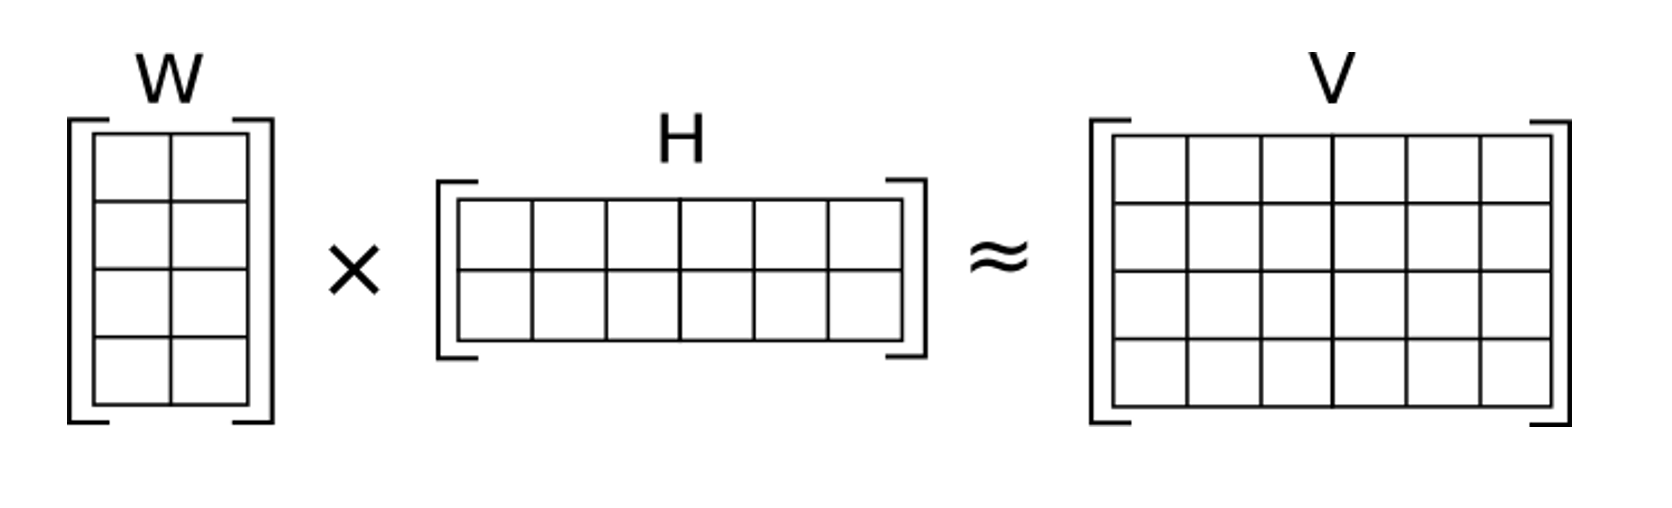
<font size="1">Image Credit: https://en.wikipedia.org/wiki/File:NMF.png
</font>

Here, k is a free parameter that denotes the rank of the factorization. *W* and *H* are selected such that our cost function is minimized. Typically the cost function is defined as ||*V* - *WH*||. Essentially, this means we want to minimize the reconstruciton error. The problem of finding an optimal *W* and *H* is typically solved via gradient descent over several iterations until the algorithm converges on a best solution.  

NMF as a technique is very flexible, and has an array of uses within the sciences. The following short section will introduce the two most common use cases.


---
# Some Use Cases

### NMF For Dimensionality Reduction

Among NMF's most common uses is for dimenisonality reduction of complex data. This is achieved because *k* can be much smaller than either *n* or *m*, so the resulting matrices (*W* and *H*) are of reduced dimensionality with respect to the original matrix *V*. This can make working with each decomposed matrix much simpler, while minimizing information loss. 

### NMF For Clustering & Community Discovery

NMF's decomposition strategy implicitly performs clustering, and we can take advantage of this in our research. 

The decomposed matrix *H* can be understood as describing the relative membership of a node pair to a cluster. More explicitly, from the original matrix *V*, $V_{i}$'s cluster *k* membership is given by the value of $H_{ik}$. We can take the *k* that produces a maximum $H_{ik}$ as $V_{i}$'s assigned cluster. An advantage of NMF is that cluster assignments are not totally discrete, and instead we can get relative membership scores for each cluster (represented by each value of $H_{ik}$). 


---
# Applying NMF to Neuroscience

Now that we've covered some of the basics of NMF, let's walk through an example of how it may be applied in a neuroscience context. 

While the uses of NMF in neuroscience abound, for the purposes of this introduction, we will focus on a simple application of NMF on simulated connectivity data to explore the relative complexity of a subject's connectome under two conditions. This will hopefully help to build some intuition as to how NMF may be used to explore latent structure in such data.  


---
# Application Example

Let us say that we have calculated channel-to-channel connectivity from some electrophysiological recording data, resulting in 100 x 100 matrices, with each row and column correspoding to a channel, and each element correspoding to the connectivity between the respective channels. 

We want to compare the relative complexity of the structure of one individual's connectivity matrix under two conditions (Condition A and Condition B). We can take advantage of the fact that we can modulate the k parameter (number of clusters) in NMF to get a sense of this. 

To do this, we will simulate one subject's connectivity data for each condition, and apply NMF with varying k size to both simulated datasets, and compare the relationship between reconstruction error and k in each case. 

Let's walk through how we could implement this in our code.

---
# Setup

First, let's get some imports and setup out of the way

In [ ]:
#@title Import Statements
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

We'll start by simulating connectivity data for one subject under Condition A, and Condition B, and visualizing the connectomes. 

We can take advantage of the Networkx package's built in network simulator tool to create some stochastic block model connectomes with pre-specified community structure. Don't worry about the details of the simulation, just know that one connectome will be highly clustered, and the other will be less so. 

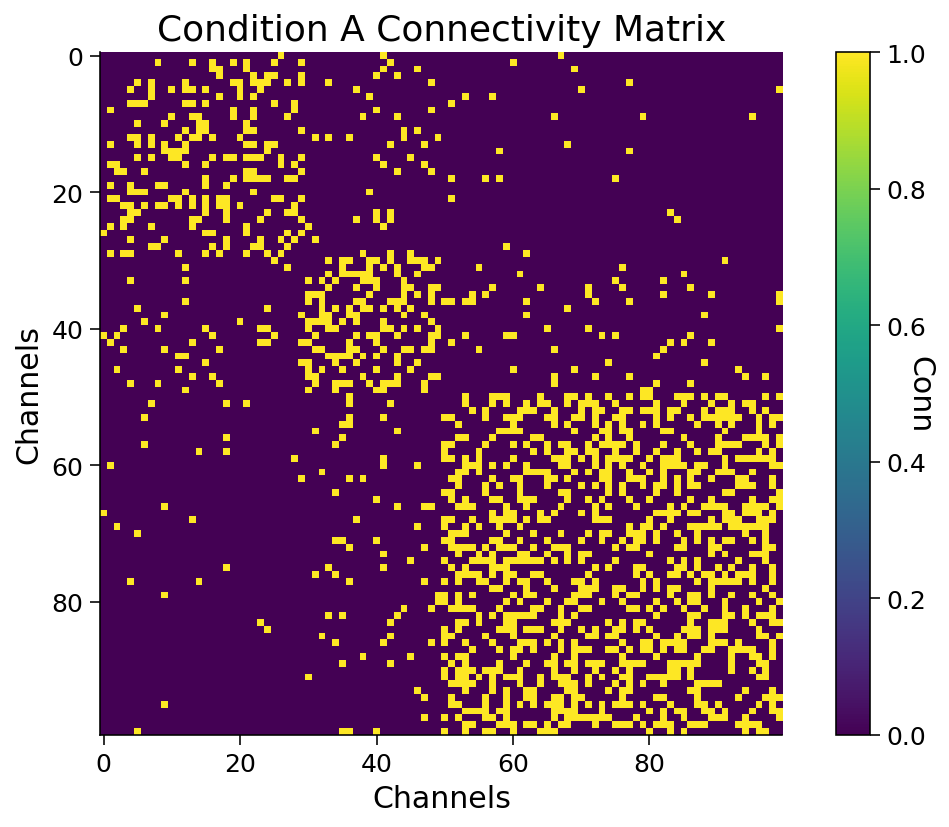

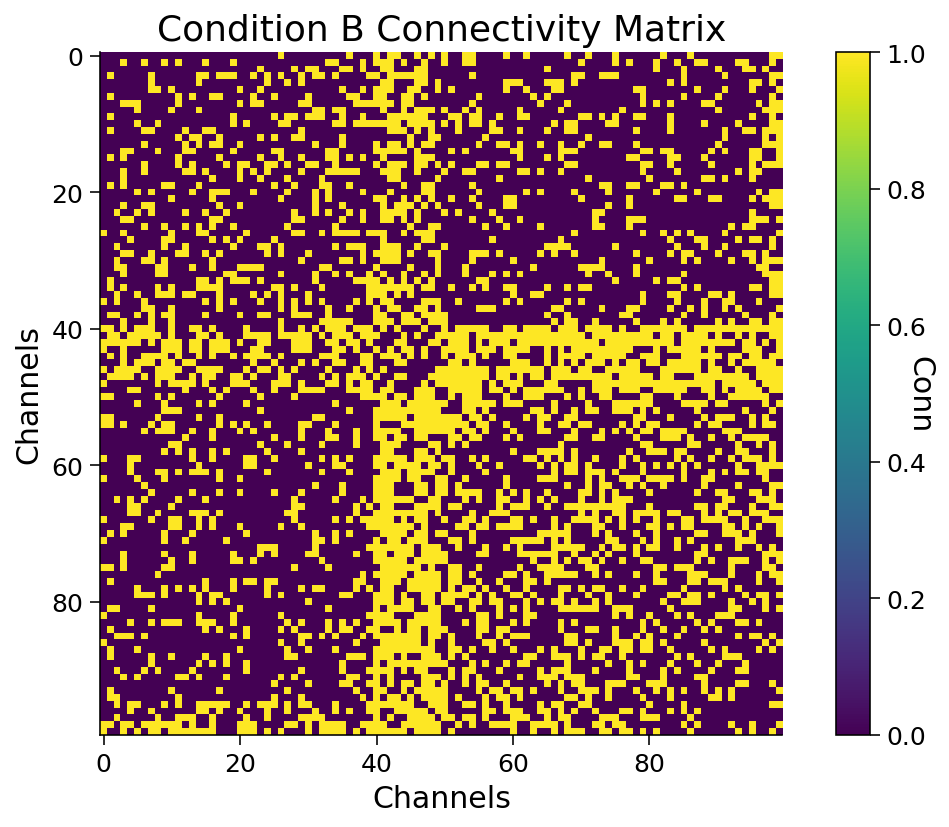

In [ ]:
# Simulate Condition A Data
sizes = [30, 20, 50] # cluster sizes
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]] # stochasticity
G = nx.stochastic_block_model(sizes, probs, seed=0, selfloops=False) # generate matrix
Condition_A = nx.convert_matrix.to_numpy_array(G) # extract simulated data

# Simulate Condition B Data
sizes2 = [40, 10, 20, 25, 5] # cluster sizes
probs2 = [[0.25, 0.5, 0.2, 0.2, 0.4], [0.5, 0.35, 0.7, 0.7, 0.7], [0.2, 0.7, 0.40, 0.4, 0.4], [0.2, 0.7, 0.40, 0.3, 0.3], [0.4, 0.7, 0.40, 0.3, 0.4]] # stochasticity
G2 = nx.stochastic_block_model(sizes2, probs2, seed=0, selfloops=False) # generate matrix
Condition_B = nx.convert_matrix.to_numpy_array(G2) # extract simulated data

# Visualize Condition A
plt.imshow(Condition_A)
plt.title("Condition A Connectivity Matrix")
plt.xlabel("Channels")
plt.ylabel("Channels")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Conn', rotation=270)
plt.show()

# Visualize Condition B
plt.imshow(Condition_B)
plt.title("Condition B Connectivity Matrix")
plt.xlabel("Channels")
plt.ylabel("Channels")
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Conn', rotation=270)
plt.show()

Great! By plotting out the simulated data we can see the organization of these matrices is vastly different. 

Now, let's apply NMF on these matrices to get a better understanding of these differences. We can take advantage of scikit-learn's built in NMF implementation for this example. This runs a standard NMF, though in reality, neural connectivity data can be better explored with modified forms of NMF such as Symmetric NMF. We'll mention some of these subtypes later on, but for this example, standard NMF will be sufficient. 

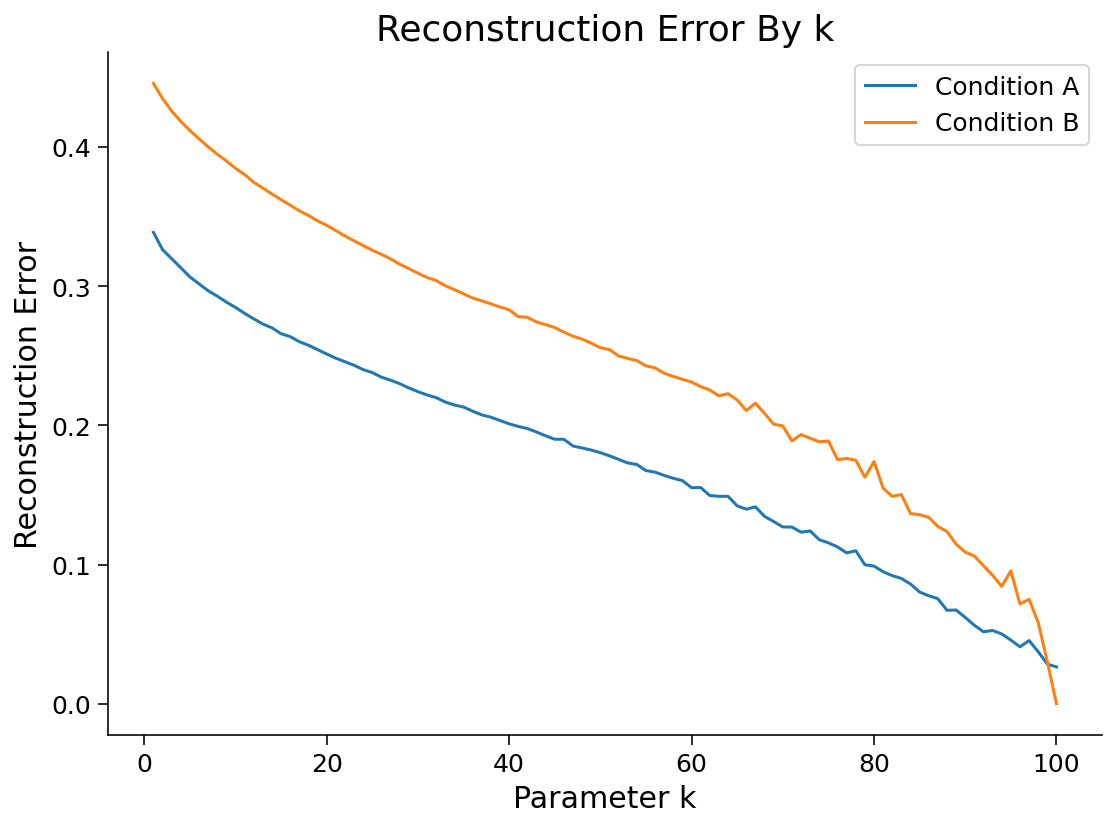

In [ ]:
max_k = 100 # set the maximum number of k to test. This is generally set to be the number of nodes (indicating a maximally complex model, where each node is a community)

error_by_k_A = [] # store reconstruction error for each run of NMF on Condition A
error_by_k_B = [] # store reconstruction error for each run of NMF on Condition B
for k in range(1,max_k+1):

  model = NMF(n_components=k, init='random', random_state=0) # generate an NMF model with the given k size

  # run NMF on the first matrix
  U = model.fit_transform(Condition_A) # run model on Condition A at this k
  V = model.components_
  # calculate reconstruction error at this k and save it
  error_by_k_A.append(np.linalg.norm(Condition_A - np.matmul(U,V), ord='fro')/math.sqrt(Condition_A.shape[0]*Condition_A.shape[0])) 

  # run NMF on the second matrix
  U2 = model.fit_transform(Condition_B) # run model on Condition B at this k
  V2 = model.components_
  # calculate reconstruction error at this k and save it
  error_by_k_B.append(np.linalg.norm(Condition_B - np.matmul(U2,V2), ord='fro')/math.sqrt(Condition_B.shape[0]*Condition_B.shape[0]))

# Plot reconstuction error as a function of k for each matrix (Condition A, Condition B)
plt.plot(list(range(1, max_k+1)), error_by_k_A)
plt.plot(list(range(1, max_k+1)), error_by_k_B)
plt.title("Reconstruction Error By k")
plt.xlabel("Parameter k")
plt.ylabel("Reconstruction Error")
plt.legend(["Condition A", "Condition B"])
plt.show()


From this analysis, we can see that connectivity under Condition A can be better explained with fewer components. This is because the matrix we simulated for Condition A is far more modular than that of Condition B. 

In this example, since we defined the community structure of our matrices, this expected result is not especially insightful. However, when analyzing real-world data, where community organization is more ambiguous, and differences more subtle, this sort of analysis can be highly useful. 

Additionally, this is useful because it gives us a way of quantifying information about features of a matrix's global community structure. 

--- 
# Subtypes of NMF

The flexibility and simplicity of NMF has allowed the method to be modified for different use cases. Many of these can better serve different kinds of neural data, and I encourage you to follow the links here and browse papers that discuss some NMF subtypes and their respective use cases. Symmetric NMF, for example, which imposes a symmetry constraint on decomposition, is especially suited to evaluating connectivity matrices (since these are necessarily symmetrical in structure). Happy learning!

[Symmetric NMF](https://www.cc.gatech.edu/~hpark/papers/DaDingParkSDM12.pdf)

[Dynamic NMF](https://arxiv.org/pdf/1305.7169.pdf)

[Sparse NMF](https://www.cc.gatech.edu/~hpark/papers/GT-CSE-08-01.pdf)

[Collective Sparse NMF](https://core.ac.uk/reader/132207436?utm_source=linkout)

---
# Summary

What have we learned?
* What NMF is

* The basics of how NMF works

* How we can use NMF as an analytic tool

* How to apply NMF to explore relative complexity in connectivity data
